In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import math

In [44]:
def shortest_paths(G):
    #this gives a dictionary of all shortest paths from all nodes
    #G is a nx.graph, can compute either from G=nx.Graph or G=nx.from_numpy_matrix(A) where A is adjacency matrix
    P = [ {} for _ in range(1, len(G._node) + 1) ]
    Q = {}
    for i in range(0, len(G._node) ):
        for j in range(0, len(G._node)):
            P[i][j] = [v for v in nx.all_shortest_paths(G, source=i, target=j)]
        Q[i] = P[i] 
    return Q

def num_of_elements_of_length_k(lst, k):
    #lst: a list in the form {1: [[a, b], [c, d]], 2: [[e]]}
    #k: the required length
    i = 0
    idx_set = {}
    for idx in range(0, len(lst)):
        if len(lst[idx][0]) == k:
            idx_set[i] = idx
            i = i + len(lst[idx])
    return i, idx_set

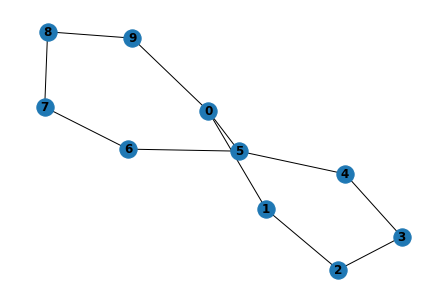

In [45]:
G1 = nx.cycle_graph(10)
G1.add_edge(0, 5)

G21 = nx.cycle_graph(5)
G22 = nx.cycle_graph(5)
mapping = {i: i+5 for i in range(5)}
G22 = nx.relabel_nodes(G22, mapping)
G2 = nx.union(G21, G22)
G2.add_edge(0, 5)

nx.draw(G1, with_labels=True, font_weight='bold')

In [46]:
features = {}
for i in range(len(G1)):
    l = dict(enumerate(np.ones(10)))
    features[i] = l
nx.set_node_attributes(G1, features)

In [47]:
G1.nodes[1]

{0: 1.0,
 1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0}

In [59]:
def sub_vectors_between(set_vectors, a, b):
    # this function selects a set of vectors whose entries are between a and b
    
    filtered_vector = [[x for x in v if a < x < b] for v in set_vectors ]
    return filtered_vector        

def list_vector_indices_upto(list_indices, list_of_nums):
    result_list = [[list_indices[i][j] for j in range(list_of_nums[i] + 1)] for i in range(len(list_indices))]
    return result_list

def list_vector_of_index(set_vectors, list_indices):
    
    list_result_vectors = [np.array([set_vectors[i] for i in list_indices[j]]) for j in range(len(list_indices))]
    return list_result_vectors 



def find_stalks_graph(G, x, hop_PCA = 1, stalk_dim = 2):
    #G: the nx.Graph
    #x: label of the node, shape of 1 by n, the point where the basis is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    hop_PCA = hop_PCA
    
    # Number of neighbors at x of hop_PCA steps 
    k = num_of_elements_of_length_k(shortest_paths(G)[x], hop_PCA + 1)[0]
    
    # Select the node of neighbors
    nbrs = num_of_elements_of_length_k(shortest_paths(G)[x], hop_PCA + 1)[1]
    if len(nbrs) == 0:
        O_i = np.array([0])
    elif len(nbrs) == 1:
        O_i = np.array(list(G.nodes[nbrs[0]].values())) -  np.array(list(G.nodes[x].values()))
    else:
        X_i = []
        for i in range(len(nbrs)):
            xi = np.array(list(G.nodes[nbrs[i]].values()))
            x0 = np.array(list(G.nodes[x].values()))
            dist = xi - x0
            X_i.append(dist)
            #X_i.append(xi)
        X_i = np.vstack(X_i)
        prob = []
        for i in nbrs.values():
            nn = len(list(G.neighbors(i)))
            prob.append(nn)
        D_i = np.diag(prob) / sum(prob)
        B_i = X_i.T @ D_i
        U, S, VT = np.linalg.svd(B_i, full_matrices = False)
        #dim = len(nbrs) + stalk_dim
        O_i = U[:, :stalk_dim]
        
    return  O_i

def transport_map_graphs(G):
    transport_maps = {}
    for i in G.nodes:
        O_i = find_stalks_graph(G, i)
        transport_maps_j = {}
        for j in G.nodes:
            O_j = find_stalks_graph(G, j)
            if i == j:
                O_ij = np.identity(O_j.shape[0])
                transport_maps_j[j] = O_ij
            elif G.has_edge(i, j):
                U, S, VT = np.linalg.svd(O_i.T @ O_j, full_matrices = False)
                O_ij = U @ VT
                transport_maps_j[j] = O_ij
            else:
                transport_maps_j[j] = np.array([0])
        transport_maps[i] = transport_maps_j
    return transport_maps
                
                
            
            
                
                
    

In [63]:
Coor = []
for i in G1.nodes:
    aggregation = []
    for j in list(G1.neighbors(i)):
        k = np.array(find_stalks_graph(G1, j, hop_PCA = 1) @ transport_map_graphs(G1)[j][i])
        
        aggregation.append(k)
    aggregated = sum(aggregation)/len(list(G1.neighbors(i)))
    U, S, V= np.linalg.svd(aggregated.T, full_matrices = False)
    print(S)
    Coor.append(U[0])


[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]


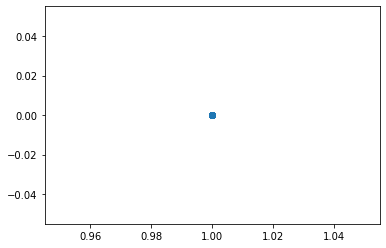

In [64]:
Coor = np.vstack(Coor)
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(Coor[:, 0], Coor[:, 1])
plt.show()

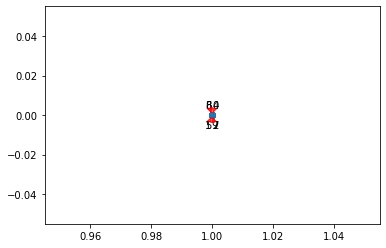

In [65]:
from adjustText import adjust_text

fig, ax = plt.subplots()
ax.scatter(Coor[:, 0], Coor[:, 1])
labels = ['{}'.format(i) for i in range(len(G1))]
texts = []
for x, y, text in zip(Coor[:, 0], Coor[:, 1], labels):
    texts.append(ax.text(x, y, text))
adjust_text(texts, force_text=0.05, arrowprops=dict(arrowstyle="-|>",color='r', alpha=0.5))
plt.show()

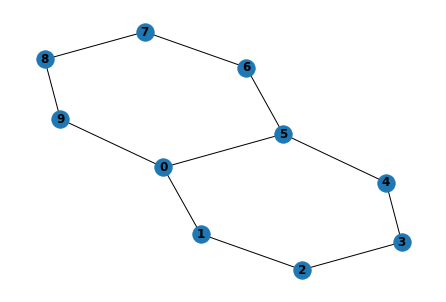

In [53]:
nx.draw(G1, with_labels=True, font_weight='bold')

In [21]:
G1.neighbors(0)

In [22]:
np.diag([1,2,3])

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])